In [21]:
# Import modules and packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from datetime import datetime, timedelta
import shrimpy
import psycopg2
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard

In [22]:
class DatabaseClient:
    """
    Functionality for inserting and reading from the database
    """

    def __init__(self):
        # Connect to db
        self.con = psycopg2.connect(
            host='localhost',
            database='postgres',
            user='postgres',
            password='postgres'
        )
        self.article_table = pd.DataFrame()

    def read_db(self):
        cur = self.con.cursor()

        cur.execute("SELECT timestamp, comp_sentiment, sma, ema FROM sent_values WHERE timestamp > '2021-01-26 15:00:00'::timestamp;")

        rows = cur.fetchall()

        self.article_table = pd.DataFrame(data=rows, columns=['timestamp','compound','sma','ema'])


        return self.article_table

In [23]:
def get_latest_prices(trading_symbol):
    public_key = '12326758a39a720e15d064cab3c1f0a9332d107de453bd41926bb3acd565059e'
    secret_key = '6991cf4c9b518293429db0df6085d1731074bed8abccd7f0279a52fac5b0c1a8a2f6d28e11a50fbb1c6575d1407e637f9ad7c73fbddfa87c5d418fd58971f829'
    
    client = shrimpy.ShrimpyApiClient(public_key, secret_key)
        
    # get the candles for historical values
    candles = client.get_candles(
        'binance',  # exchange
        trading_symbol,      # base_trading_symbol
        'USDT',      # quote_trading_symbol
        '1h'       # interval
    )
        
    # Set the dataframe between these two dates
    tomorrows_date = (datetime.today() - timedelta(hours=1)).strftime("%Y-%m-%d %H:00")
    tomorrows_date = (datetime.today()).strftime("%Y-%m-%d %H:00")
    starting_date = '2021-01-25 02:00:00'

    # Put pulled cryptocurrency values into a dataframe and set dates
    prices_df = pd.DataFrame(candles)
    prices_df['time'] = pd.to_datetime(prices_df['time'], infer_datetime_format=True).dt.tz_localize(None)

    latest_prices = prices_df[(prices_df['time'] > starting_date) & (prices_df['time'] <tomorrows_date)]
    latest_prices['close'] = latest_prices['close'].astype('float64')

    return latest_prices

In [28]:
database_client = DatabaseClient()
df = database_client.read_db()
df.index = df.timestamp
df = df.iloc[:-1]

data = get_latest_prices('BTC')
data.index = data.time
data = data.iloc[:-4]

dataset_train = data.join(df, lsuffix=data.index, rsuffix=df.index)
dataset_train = dataset_train.drop(columns=['open', 'high', 'low', 'volume', 'quoteVolume', 'btcVolume', 'usdVolume','time','timestamp'])

comp_df = dataset_train[['close', 'compound']]
comp_df = comp_df.astype('float')
df = comp_df.dropna()

<ipython-input-23-b1d27c6bb073>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  latest_prices['close'] = latest_prices['close'].astype('float64')


# Data Preprocessing

In [29]:
# Select features (columns) to be involved intro training and predictions
cols = list(dataset_train)[0:2]

# Extract dates (will be used in visualization)
datelist_train = list(dataset_train.index)
datelist_train = [dt.datetime.strftime(date, '%Y-%m-%d %H:00:00') for date in datelist_train]

print('Training set shape == {}'.format(dataset_train.shape))
print('All timestamps == {}'.format(len(datelist_train)))
print('Featured selected: {}'.format(cols))

Training set shape == (986, 4)
All timestamps == 986
Featured selected: ['close', 'compound']


In [30]:
dataset_train = df.astype(float)

# Using multiple features (predictors)
training_set = dataset_train.values

print('Shape of training set == {}.'.format(training_set.shape))
training_set

Shape of training set == (309, 2).


array([[ 3.761331e+04,  5.994000e-01],
       [ 3.764300e+04,  7.096000e-01],
       [ 3.724000e+04,  9.984000e-01],
       [ 3.693666e+04, -6.597000e-01],
       [ 3.699325e+04,  7.906000e-01],
       [ 3.726678e+04, -5.859000e-01],
       [ 3.706597e+04,  7.906000e-01],
       [ 3.770527e+04,  3.074000e-01],
       [ 3.725107e+04,  9.990000e-01],
       [ 3.739591e+04,  0.000000e+00],
       [ 3.785036e+04, -9.997000e-01],
       [ 3.827232e+04,  5.574000e-01],
       [ 3.809502e+04,  9.853000e-01],
       [ 3.774039e+04,  9.771000e-01],
       [ 3.781967e+04, -5.574000e-01],
       [ 3.778412e+04,  7.800000e-03],
       [ 3.829024e+04, -2.120000e-02],
       [ 3.874092e+04,  9.970000e-01],
       [ 3.938210e+04,  9.040000e-02],
       [ 3.938474e+04,  9.682000e-01],
       [ 3.917956e+04, -6.486000e-01],
       [ 3.926747e+04,  4.266000e-01],
       [ 3.988791e+04,  2.450000e-02],
       [ 3.999863e+04, -2.719000e-01],
       [ 3.990249e+04,  3.688000e-01],
       [ 4.013047e+04, -5

In [31]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
training_set_scaled = sc.fit_transform(training_set)

sc_predict = StandardScaler()
sc_predict.fit_transform(training_set[:, 0:1])

array([[-1.97389978],
       [-1.96843962],
       [-2.04255364],
       [-2.09833961],
       [-2.08793238],
       [-2.03762864],
       [-2.07455875],
       [-1.95698781],
       [-2.0405178 ],
       [-2.01388089],
       [-1.93030492],
       [-1.85270405],
       [-1.88531054],
       [-1.95052904],
       [-1.93594899],
       [-1.94248684],
       [-1.84940846],
       [-1.76652582],
       [-1.64860913],
       [-1.64812362],
       [-1.6858574 ],
       [-1.66969025],
       [-1.55558776],
       [-1.53522572],
       [-1.55290642],
       [-1.51097958],
       [-1.48560611],
       [-1.37594495],
       [-1.4230193 ],
       [-1.4987425 ],
       [-1.48414038],
       [-1.5019774 ],
       [-1.51890041],
       [-1.52978946],
       [-1.53630341],
       [-1.68450018],
       [-1.76535066],
       [-1.80880943],
       [-1.62748572],
       [-1.62436667],
       [-1.65792947],
       [-1.71030951],
       [-1.75182255],
       [-1.86324921],
       [-1.91729359],
       [-1

In [32]:
# Creating a data structure with 90 timestamps and 1 output
X_train = []
y_train = []

n_future = 60   # Number of days we want top predict into the future
n_past = 90     # Number of past days we want to use to predict the future

for i in range(n_past, len(training_set_scaled) - n_future +1):
    X_train.append(training_set_scaled[i - n_past:i, 0:dataset_train.shape[1] - 1])
    y_train.append(training_set_scaled[i + n_future - 1:i + n_future, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

print('X_train shape == {}.'.format(X_train.shape))
print('y_train shape == {}.'.format(y_train.shape))

X_train shape == (160, 90, 1).
y_train shape == (160, 1).


# Create Model

In [33]:
# Import Libraries and packages from Keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.optimizers import Adam

In [34]:

# Initializing the Neural Network based on LSTM
model = Sequential()

# Adding 1st LSTM layer
model.add(LSTM(units=64, return_sequences=True, input_shape=(n_past, dataset_train.shape[1]-1)))

# Adding 2nd LSTM layer
model.add(LSTM(units=10, return_sequences=False))

# Adding Dropout
model.add(Dropout(0.25))

# Output layer
model.add(Dense(units=1, activation='linear'))

# Compiling the Neural Network
model.compile(optimizer = Adam(learning_rate=0.01), loss='mean_squared_error')

In [35]:
%%time
#es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=10, verbose=1)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1)
mcp = ModelCheckpoint(filepath='weights.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)

tb = TensorBoard('logs')

history = model.fit(X_train, y_train, shuffle=True, epochs=100, callbacks=[es, rlr, mcp, tb], validation_split=0.2, verbose=1, batch_size=256)

Epoch 1/100
1/1 [==============================] - 5s 5s/step - loss: 0.6061 - val_loss: 1.4410

Epoch 00001: val_loss improved from inf to 1.44104, saving model to weights.h5
Epoch 2/100
1/1 [==============================] - 2s 2s/step - loss: 0.5640 - val_loss: 1.2829

Epoch 00002: val_loss improved from 1.44104 to 1.28295, saving model to weights.h5
Epoch 3/100
1/1 [==============================] - 0s 131ms/step - loss: 0.4429 - val_loss: 0.9887

Epoch 00003: val_loss improved from 1.28295 to 0.98867, saving model to weights.h5
Epoch 4/100
1/1 [==============================] - 0s 131ms/step - loss: 0.3101 - val_loss: 0.4259

Epoch 00004: val_loss improved from 0.98867 to 0.42592, saving model to weights.h5
Epoch 5/100
1/1 [==============================] - 0s 128ms/step - loss: 0.2571 - val_loss: 0.4091

Epoch 00005: val_loss improved from 0.42592 to 0.40909, saving model to weights.h5
Epoch 6/100
1/1 [==============================] - 0s 124ms/step - loss: 0.2131 - val_loss: 0.4

# Make future predictions

In [37]:
# Extract dates (will be used in visualization)
datelist_train = list(dataset_train.index)

# Generate list of sequence of days for predictions
datelist_future = pd.date_range(datelist_train[-1], periods=n_future, freq='H').tolist()

'''
Remeber, we have datelist_train from begining.
'''

# Convert Pandas Timestamp to Datetime object (for transformation) --> FUTURE
datelist_future_ = []
for this_timestamp in datelist_future:
    datelist_future_.append(this_timestamp.date())

In [38]:
# Generate list of sequence of days for predictions
datelist_future = pd.date_range(end=datelist_train[-1], periods=n_future, freq='H').tolist()

'''
Remeber, we have datelist_train from begining.
'''

# Convert Pandas Timestamp to Datetime object (for transformation) --> FUTURE
datelist_future_ = []
for this_timestamp in datelist_future:
    datelist_future_.append(this_timestamp.date())

In [39]:
# Perform predictions
predictions_future = model.predict(X_train[-n_future:])

predictions_train = model.predict(X_train[n_past:])

In [40]:
# Inverse the predictions to original measurements

# ---> Special function: convert <datetime.date> to <Timestamp>
def datetime_to_timestamp(x):
    '''
        x : a given datetime value (datetime.date)
    '''
    return datetime.strptime(x.strftime('%Y%m%d %H:%M'), '%Y%m%d %H:%M')


y_pred_future = sc_predict.inverse_transform(predictions_future)
y_pred_train = sc_predict.inverse_transform(predictions_train)

PREDICTIONS_FUTURE = pd.DataFrame(y_pred_future, columns=['close']).set_index(pd.Series(datelist_future))
PREDICTION_TRAIN = pd.DataFrame(y_pred_train, columns=['close']).set_index(pd.Series(datelist_train[2 * n_past + n_future -1:]))

# Convert <datetime.date> to <Timestamp> for PREDCITION_TRAIN
PREDICTION_TRAIN.index = PREDICTION_TRAIN.index.to_series()

PREDICTION_TRAIN.head(3)

,close
2021-03-03 06:00:00,49114.457031
2021-03-03 08:00:00,49650.406250
2021-03-03 09:00:00,50137.644531


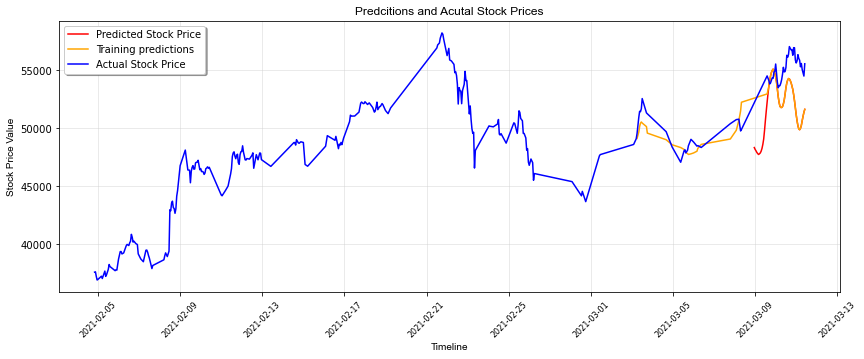

In [41]:
# Set plot size 
from pylab import rcParams
rcParams['figure.figsize'] = 14, 5

# Plot parameters
START_DATE_FOR_PLOTTING = '2021-02-01'

plt.plot(PREDICTIONS_FUTURE.index, PREDICTIONS_FUTURE['close'], color='r', label='Predicted Stock Price')
plt.plot(PREDICTION_TRAIN.loc[START_DATE_FOR_PLOTTING:].index, PREDICTION_TRAIN.loc[START_DATE_FOR_PLOTTING:]['close'], color='orange', label='Training predictions')
plt.plot(dataset_train.loc[START_DATE_FOR_PLOTTING:].index, dataset_train.loc[START_DATE_FOR_PLOTTING:]['close'], color='b', label='Actual Stock Price')

#plt.axvline(x = min(PREDICTIONS_FUTURE.index), color='green', linewidth=2, linestyle='--')

plt.grid(which='major', color='#cccccc', alpha=0.5)

plt.legend(shadow=True)
plt.title('Predcitions and Acutal Stock Prices', family='Arial', fontsize=12)
plt.xlabel('Timeline', family='Arial', fontsize=10)
plt.ylabel('Stock Price Value', family='Arial', fontsize=10)
plt.xticks(rotation=45, fontsize=8)
plt.show()

In [28]:
lstm_rms=np.sqrt(np.mean(np.power((PREDICTIONS_FUTURE['close']-PREDICTION_TRAIN.loc[START_DATE_FOR_PLOTTING:]['close']),2)))
lstm_rms

1058.5876203697076

# Model With Bins

In [14]:
bin_labels = [-1, -0.01, 0, 0.01, 1]

dataset_train = df.astype('float')

dataset_train['bin'] = pd.qcut(dataset_train['sma'], q=5, labels=bin_labels)

In [16]:
# Select features (columns) to be involved intro training and predictions
data = dataset_train[['close', 'bin']]

# Select features (columns) to be involved intro training and predictions
cols = list(data)

# Extract dates (will be used in visualization)
datelist_train = list(dataset_train.index)
datelist_train = [dt.datetime.strftime(date, '%Y-%m-%d %H:00:00') for date in datelist_train]

print('Training set shape == {}'.format(dataset_train.shape))
print('All timestamps == {}'.format(len(datelist_train)))
print('Featured selected: {}'.format(cols))

Training set shape == (803, 4)
All timestamps == 803
Featured selected: ['close', 'bin']


In [17]:
dataset_train = dataset_train.astype(float)

# Using multiple features (predictors)
training_set = dataset_train.values

print('Shape of training set == {}.'.format(training_set.shape))
training_set

Shape of training set == (803, 4).


array([[ 3.576203e+04,  3.899000e-01,  3.588000e-01,  1.000000e-02],
       [ 3.578651e+04,  3.673000e-01,  3.588000e-01,  1.000000e-02],
       [ 3.565307e+04,  3.673000e-01,  3.588000e-01,  1.000000e-02],
       ...,
       [ 5.476102e+04, -1.152000e-01, -7.562000e-01, -1.000000e+00],
       [ 5.447427e+04, -3.896000e-01, -7.574000e-01, -1.000000e+00],
       [ 5.553060e+04, -3.756000e-01, -5.433000e-01, -1.000000e+00]])

In [18]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
training_set_scaled = sc.fit_transform(training_set)

sc_predict = StandardScaler()
sc_predict.fit_transform(training_set[:, 0:1])

array([[-2.19153488e+00],
       [-2.18702371e+00],
       [-2.21161403e+00],
       [-2.22648726e+00],
       [-2.24604305e+00],
       [-2.12280215e+00],
       [-2.16992990e+00],
       [-2.16806868e+00],
       [-2.07333036e+00],
       [-2.03179735e+00],
       [-2.06289090e+00],
       [-2.04892617e+00],
       [-2.09284561e+00],
       [-2.14582240e+00],
       [-2.17510448e+00],
       [-2.15039623e+00],
       [-2.15331891e+00],
       [-2.11472148e+00],
       [-2.04864606e+00],
       [-2.04658581e+00],
       [-1.99104384e+00],
       [-1.93637351e+00],
       [-1.93081010e+00],
       [-1.94236814e+00],
       [-2.00230519e+00],
       [-1.95605277e+00],
       [-1.91604744e+00],
       [-1.91248346e+00],
       [-1.84935653e+00],
       [-1.76748464e+00],
       [-1.75196827e+00],
       [-1.79822069e+00],
       [-1.87148671e+00],
       [-1.83838819e+00],
       [-1.85684566e+00],
       [-1.76503740e+00],
       [-1.80798015e+00],
       [-1.90108022e+00],
       [-1.8

In [19]:
# Creating a data structure with 90 timestamps and 1 output
X_train = []
y_train = []

n_future = 60   # Number of days we want top predict into the future
n_past = 90     # Number of past days we want to use to predict the future

for i in range(n_past, len(training_set_scaled) - n_future +1):
    X_train.append(training_set_scaled[i - n_past:i, 0:dataset_train.shape[1] - 1])
    y_train.append(training_set_scaled[i + n_future - 1:i + n_future, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

print('X_train shape == {}.'.format(X_train.shape))
print('y_train shape == {}.'.format(y_train.shape))

X_train shape == (654, 90, 3).
y_train shape == (654, 1).


In [20]:
# Import Libraries and packages from Keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.optimizers import Adam

In [21]:
# Initializing the Neural Network based on LSTM
model = Sequential()

# Adding 1st LSTM layer
model.add(LSTM(units=64, return_sequences=True, input_shape=(n_past, dataset_train.shape[1]-1)))

# Adding 2nd LSTM layer
model.add(LSTM(units=10, return_sequences=False))

# Adding Dropout
model.add(Dropout(0.25))

# Output layer
model.add(Dense(units=1, activation='linear'))

# Compiling the Neural Network
model.compile(optimizer = Adam(learning_rate=0.01), loss='mean_squared_error')

In [22]:
%%time
es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=10, verbose=1)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1)
mcp = ModelCheckpoint(filepath='weights.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)

tb = TensorBoard('logs')

history = model.fit(X_train, y_train, shuffle=True, epochs=30, callbacks=[es, rlr, mcp, tb], validation_split=0.2, verbose=1, batch_size=256)

Epoch 1/30
3/3 [==============================] - 6s 1s/step - loss: 0.4268 - val_loss: 0.4716

Epoch 00001: val_loss improved from inf to 0.47159, saving model to weights.h5
Epoch 2/30
3/3 [==============================] - 0s 116ms/step - loss: 0.3158 - val_loss: 0.4981

Epoch 00002: val_loss did not improve from 0.47159
Epoch 3/30
3/3 [==============================] - 0s 121ms/step - loss: 0.2763 - val_loss: 0.3534

Epoch 00003: val_loss improved from 0.47159 to 0.35338, saving model to weights.h5
Epoch 4/30
3/3 [==============================] - 0s 136ms/step - loss: 0.2720 - val_loss: 0.8514

Epoch 00004: val_loss did not improve from 0.35338
Epoch 5/30
3/3 [==============================] - 0s 119ms/step - loss: 0.2269 - val_loss: 1.3074

Epoch 00005: val_loss did not improve from 0.35338
Epoch 6/30
3/3 [==============================] - 0s 163ms/step - loss: 0.1820 - val_loss: 1.7279

Epoch 00006: val_loss did not improve from 0.35338
Epoch 7/30
3/3 [===========================

In [23]:
# Extract dates (will be used in visualization)
datelist_train = list(dataset_train.index)

# Generate list of sequence of days for predictions
datelist_future = pd.date_range(datelist_train[-1], periods=n_future, freq='H').tolist()

'''
Remeber, we have datelist_train from begining.
'''

# Convert Pandas Timestamp to Datetime object (for transformation) --> FUTURE
datelist_future_ = []
for this_timestamp in datelist_future:
    datelist_future_.append(this_timestamp.date())

In [24]:
# Generate list of sequence of days for predictions
datelist_future = pd.date_range(end=datelist_train[-1], periods=n_future, freq='H').tolist()

'''
Remeber, we have datelist_train from begining.
'''

# Convert Pandas Timestamp to Datetime object (for transformation) --> FUTURE
datelist_future_ = []
for this_timestamp in datelist_future:
    datelist_future_.append(this_timestamp.date())

In [25]:
# Perform predictions
predictions_future = model.predict(X_train[-n_future:])

predictions_train = model.predict(X_train[n_past:])

In [26]:
# Inverse the predictions to original measurements

# ---> Special function: convert <datetime.date> to <Timestamp>
def datetime_to_timestamp(x):
    '''
        x : a given datetime value (datetime.date)
    '''
    return datetime.strptime(x.strftime('%Y%m%d %H:%M'), '%Y%m%d %H:%M')


y_pred_future = sc_predict.inverse_transform(predictions_future)
y_pred_train = sc_predict.inverse_transform(predictions_train)

PREDICTIONS_FUTURE = pd.DataFrame(y_pred_future, columns=['close']).set_index(pd.Series(datelist_future))
PREDICTION_TRAIN = pd.DataFrame(y_pred_train, columns=['close']).set_index(pd.Series(datelist_train[2 * n_past + n_future -1:]))

# Convert <datetime.date> to <Timestamp> for PREDCITION_TRAIN
PREDICTION_TRAIN.index = PREDICTION_TRAIN.index.to_series()

PREDICTION_TRAIN.head(3)

,close
2021-02-12 20:00:00,47710.792969
2021-02-12 21:00:00,47722.433594
2021-02-12 22:00:00,47768.097656


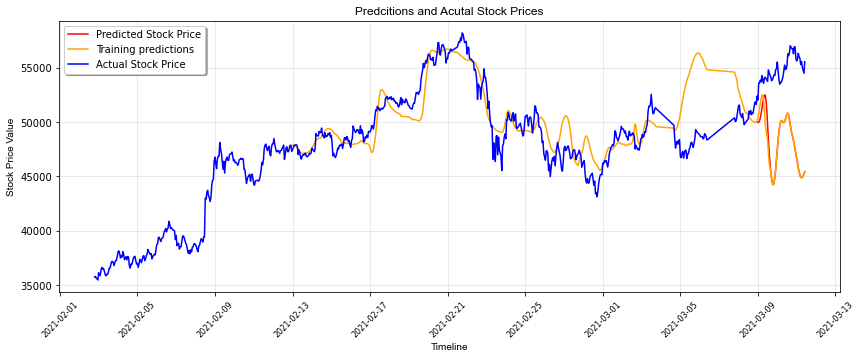

In [27]:
# Set plot size 
from pylab import rcParams
rcParams['figure.figsize'] = 14, 5

# Plot parameters
START_DATE_FOR_PLOTTING = '2021-02-01'

plt.plot(PREDICTIONS_FUTURE.index, PREDICTIONS_FUTURE['close'], color='r', label='Predicted Stock Price')
plt.plot(PREDICTION_TRAIN.loc[START_DATE_FOR_PLOTTING:].index, PREDICTION_TRAIN.loc[START_DATE_FOR_PLOTTING:]['close'], color='orange', label='Training predictions')
plt.plot(dataset_train.loc[START_DATE_FOR_PLOTTING:].index, dataset_train.loc[START_DATE_FOR_PLOTTING:]['close'], color='b', label='Actual Stock Price')

#plt.axvline(x = min(PREDICTIONS_FUTURE.index), color='green', linewidth=2, linestyle='--')

plt.grid(which='major', color='#cccccc', alpha=0.5)

plt.legend(shadow=True)
plt.title('Predcitions and Acutal Stock Prices', family='Arial', fontsize=12)
plt.xlabel('Timeline', family='Arial', fontsize=10)
plt.ylabel('Stock Price Value', family='Arial', fontsize=10)
plt.xticks(rotation=45, fontsize=8)
plt.show()